In [59]:
import pandas as pd

GIT = 'https://github.com/tyokokur/tmpdat/raw/main/nfh/'
dat = pd.read_csv(GIT+'NFH_train.txt', sep='\s+', names=['parent','chiname','b','v',
                                                         'cs','gH','tH0','tH1','tH2','tH3'])
chimax = [float(i.split('.')[2][2:]) / 100 for i in dat.chiname.values]
to_train = dat.iloc[:,2:].join(pd.Series(chimax, name='chimax'))
to_train = to_train[['b','v','cs','chimax','gH','tH0','tH1','tH2','tH3']]
display(to_train.iloc[:,:3])

,b,v,cs
0,2.2,1.20,0.004
1,2.2,1.20,0.005
2,2.2,1.20,0.006
3,2.2,1.20,0.008
4,2.2,1.20,0.010
...,...,...,...
585,2.5,1.25,0.015
586,2.5,1.25,0.020
587,2.5,1.25,0.030
588,2.5,1.25,0.040


Epoch 0, loss 695.1532592773438
Epoch 1000, loss 15.901056289672852
Epoch 2000, loss 7.342600345611572
Epoch 3000, loss 5.053005218505859
Epoch 4000, loss 3.750138282775879
Epoch 5000, loss 3.2585158348083496
Epoch 6000, loss 2.825533628463745
Epoch 7000, loss 3.2230398654937744
Epoch 8000, loss 2.376183032989502
Epoch 9000, loss 2.690770387649536


TypeError: Input z must be 2D, not 4D

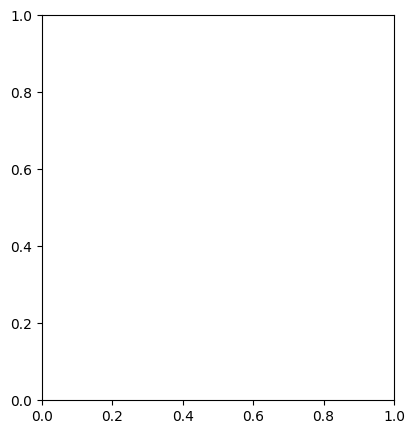

In [64]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Define the neural network architecture
class CurveFitter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(4, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the function to train the model
def train_model(model, train_input, train_target, num_epochs, optimizer, loss_fn):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_input)
        loss = loss_fn(output, train_target)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")


# Generate training data
train_input  = torch.tensor(to_train.iloc[:,:4].values, dtype=torch.float32)
train_target = torch.tensor(to_train.gH.values,  dtype=torch.float32).unsqueeze(1)

# Define the model, loss function, and optimizer
model = CurveFitter()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_input, train_target, 10000, optimizer, loss_fn)

# Generate test input values
b_test = torch.linspace(0.1, 2.5, 50)
v_test = torch.linspace(0.1, 2.5, 50)
ch_test = torch.linspace(2.8, 4.0, 50)
cs_test = torch.logspace(-3, 2, 50)
B, V, CH, CS = torch.meshgrid(b_test, v_test, ch_test, cs_test)

# Compute curve predictions for test input values
test_input = torch.stack([B.flatten(), V.flatten(), CH.flatten(), CS.flatten()], axis=1)
curve_predictions = model(test_input).detach().numpy().reshape(B.shape)

# Plot the true curve and predicted curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.contourf(B, CS, curve_predictions, levels=20, cmap='viridis')
ax.set_title('Predicted Curve')
ax.set_xlabel('b')
ax.set_ylabel('cs')

# Show the plot
plt.show()

display(curve_predictions)

In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## Globals ##
n_in  = 2
n_out = 1


# Define the target function
def target_function(x, y):
    return x**2 - y**3


# Define the neural network architecture
class CurveFitter(torch.nn.Module):
    global n_in
    global n_out 
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_in, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, n_out)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define the function to train the model
def train_model(model, train_input, train_target, num_epochs, optimizer, loss_fn):
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_input)
        loss = loss_fn(output, train_target)
        loss.backward()
        optimizer.step()
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, loss {loss.item()}")


# Generate training data
train_input = torch.empty(1000, n_in).uniform_(0, 1)
train_target = target_function(train_input[:, 0], train_input[:, 1]).unsqueeze(1)

# Define the model, loss function, and optimizer
model = CurveFitter()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
train_model(model, train_input, train_target, 10000, optimizer, loss_fn)

# Generate test input values
x_test = torch.linspace(0, 1, 100)
y_test = torch.linspace(0, 1, 100)
X, Y = torch.meshgrid(x_test, y_test)

# Compute curve predictions for test input values
test_input = torch.stack([X.flatten(), Y.flatten()], axis=1)
curve_predictions = model(test_input).detach().numpy().reshape(X.shape)

# Plot the true curve and predicted curve
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax.contourf(X, Y, target_function(X, Y), levels=20, cmap='viridis')
ax.set_title('True Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Plot the predicted curve
ax = fig.add_subplot(122)
ax.contourf(X, Y, curve_predictions, levels=20, cmap='viridis')
ax.set_title('Predicted Curve')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Show the plot
plt.show()

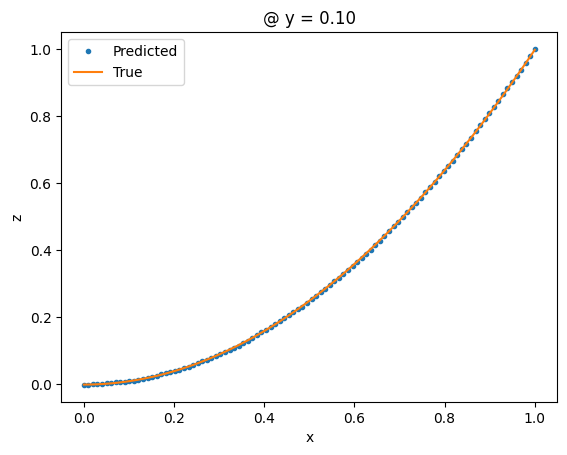

In [2]:
f, ax = plt.subplots(1,1)
yind = 10
ax.plot(X[:,yind], curve_predictions[:,yind], 'o', ms=3, label='Predicted')
ax.plot(X[:,yind], target_function(X[:,yind], Y[:,yind]), label='True')
ax.set_title('@ y = {:.2f}'.format(Y[0, yind].numpy()))
ax.set_ylabel('z')
ax.set_xlabel('x')

plt.legend()
plt.show()

In [65]:
display(curve_predictions)

array([[[[-342.39316  , -342.39267  , -342.39218  , ...,  178.8866   ,
           181.25659  ,  184.25424  ],
         [-345.49887  , -345.4985   , -345.49802  , ...,  180.15387  ,
           182.52388  ,  185.5216   ],
         [-348.6046   , -348.60425  , -348.60373  , ...,  180.87427  ,
           183.79112  ,  186.78893  ],
         ...,
         [-488.36456  , -488.36417  , -488.36362  , ...,   63.095345 ,
           202.74554  ,  243.8182   ],
         [-491.4703   , -491.46988  , -491.46936  , ...,   58.95437  ,
           201.45688  ,  245.0854   ],
         [-494.57608  , -494.57568  , -494.57516  , ...,   54.813507 ,
           200.16818  ,  246.3527   ]],

        [[-342.70645  , -342.70602  , -342.7055   , ...,  178.67618  ,
           181.04617  ,  184.04395  ],
         [-345.81223  , -345.8118   , -345.81128  , ...,  179.94344  ,
           182.31346  ,  185.31128  ],
         [-348.91797  , -348.91757  , -348.91708  , ...,  180.44365  ,
           183.58073  ,  186.5783